# Data Cleaning, EDA, and Modeling

## Imports

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from nltk.corpus import stopwords
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import (confusion_matrix, ConfusionMatrixDisplay,
    accuracy_score, recall_score,
    precision_score, f1_score)
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from bs4 import BeautifulSoup  
import regex as re

In [2]:
subredditdata = pd.read_csv("../data/subredditdata.csv")

## Cleaning

In [3]:
subredditdata.head()

,title,selftext,subreddit,created_utc,name
0,POTG with some flair,NaN,Overwatch,1.706046e+09,t3_19dzvj0
1,Blizzard will be dropping the the argentine pe...,Things here are already insanely expensive as ...,Overwatch,1.706046e+09,t3_19dztr3
2,Do you think it would be possible to file a cl...,Not saying I will. I was just thinking about i...,Overwatch,1.706046e+09,t3_19dztdr
3,Widow goes Grrahhh,NaN,Overwatch,1.706045e+09,t3_19dzfr4
4,"Fly, fly, fly! 🪽",NaN,Overwatch,1.706045e+09,t3_19dz9f8


In [4]:
subredditdata.shape

(5931, 5)

In [5]:
subredditdata.drop_duplicates(inplace=True)

# This is a precautionary measure to ensure that there are no duplicate rows that came in during data collection

In [6]:
subredditdata.isnull().sum()

title             0
selftext       3025
subreddit         0
created_utc       0
name              0
dtype: int64

In [7]:
subredditdata["selftext"].fillna("Media", inplace=True)

NaN values in the selftext category indicate that the title is the only text provided, but that it is likely accompanied by some sort of media like a photo or image that is relevant to the title. The presence of the NaN values in the selftext column could potentially still help indicate possible classifications. Due to the assumption being made, I replaced the NaN values with the string "Media" to indicate that there is an image or video present. While this produces a large outlier in the selftext feature in the form of "Media", I am confident that this will not be detrimental to the model.

In [8]:
subredditdata.isnull().sum()

title          0
selftext       0
subreddit      0
created_utc    0
name           0
dtype: int64

In [9]:
subredditdata.head()

,title,selftext,subreddit,created_utc,name
0,POTG with some flair,Media,Overwatch,1.706046e+09,t3_19dzvj0
1,Blizzard will be dropping the the argentine pe...,Things here are already insanely expensive as ...,Overwatch,1.706046e+09,t3_19dztr3
2,Do you think it would be possible to file a cl...,Not saying I will. I was just thinking about i...,Overwatch,1.706046e+09,t3_19dztdr
3,Widow goes Grrahhh,Media,Overwatch,1.706045e+09,t3_19dzfr4
4,"Fly, fly, fly! 🪽",Media,Overwatch,1.706045e+09,t3_19dz9f8


In [10]:
subredditdata["overwatch"] = [1 if i == "Overwatch" else 0 for i in subredditdata["subreddit"]]

# This creates a feature "overwatch", which tells us that a post is from the Overwatch subreddit if the value is 1
# or from the apexlegends subreddit if the value is 0

## EDA

In [11]:
subredditdata["title"].str.len().mean()

51.95016891891892

In [12]:
subredditdata["selftext"].str.len().mean()

381.22077702702705

In [13]:
X = subredditdata["selftext"]
y = subredditdata["overwatch"]

The choice to use selftext as the X feature versus title comes from the significant difference between the mean value of the two features. The higher mean value of selftext allows for the presence of more datapoints for the models to use to classify the posts in the dataset. Selftext also would be more likely to contain more complete sentence strings which may be more helpful in producing an accurate understanding of the posts.

In [14]:
y.value_counts(normalize=True)

# This established what our baseline accuracy is for our model, indicating the ratio of Overwatch to non-Overwatch posts

overwatch
1    0.501351
0    0.498649
Name: proportion, dtype: float64

The established nearly 50-50 baseline accuracy offers a helpful starting point to establish what level of accuracy they should strive to beat in classifying the posts within the two gaming subreddits.

In [15]:
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, random_state=123)

In [16]:
cvec = CountVectorizer(stop_words="english")

In [17]:
X_train_cvec = cvec.fit_transform(X_train)

In [18]:
X_test_cvec = cvec.transform(X_test)

Using CountVectorizer applies multiple text preprocessing steps at once, such as separating strings into individual words and removing stopwords that may muddy the data and make it harder to interpret and draw more conclusive predictions from.

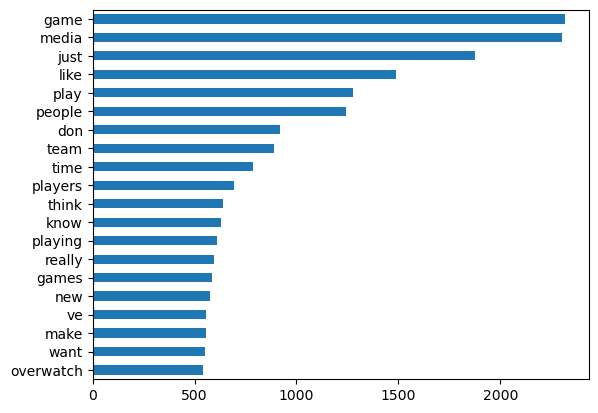

In [20]:
X_train_df = pd.DataFrame(X_train_cvec.todense(), 
                          columns=cvec.get_feature_names_out())

X_train_df.sum().sort_values().tail(20).plot(kind="barh")

plt.savefig("../Images/wordcountdist.png");

Many of the top 10 most frequently occurring words in the dataset are common in gaming settings, or may be less common generic words. With further analysis, this should show that the less frequently occurring words help to distinguish the two subreddits, therefore helping to answer the problem statement. The first word that is decidedly geared towards one subreddit or another is the 20th most frequent term "overwatch." 

## Modeling

In [26]:
scores = []

In [25]:
def evaluate(X_test, y_test, preds, model):
    ConfusionMatrixDisplay.from_estimator(model, X_test, y_test, cmap='Reds')
    
    train = model.score(X_train, y_train)
    test = model.score(X_test, y_test)
    recall = recall_score(y_test, preds, pos_label = 1)
    prec = precision_score(y_test, preds, pos_label = 1)

    print(f'Train: {train}')
    print(f'Test: {test}')
    print(f'Recall: {recall}')
    print(f'Precision: {prec}')

    return {
        'Training Accuracy': train,
        'Test Accuracy': test,
        'Recall' : recall,
        'Precision' : prec
    }

# Borrowed and adapted from Imbalanced Data lesson

The 'evaluate' function above will be used to help us compare the scores of all of the different models to determine which model might be the best for predicting the "overwatch" variable at a better rate than the baseline.

### Model Selection

In [32]:
cveclrpipe = Pipeline([
    ('cvec', CountVectorizer()),
    ('lr', LogisticRegression(max_iter=1000))
])

In [27]:
tveclrpipe = Pipeline([
    ('tvec', TfidfVectorizer()),
    ('lr', LogisticRegression(max_iter=1000))
])

Using the standard number of iterations for the logistic regressions resulted in non-convergence, but an increased number of iterations (1000, in this case) allowed the models to converge.

In [34]:
cvecmnbpipe = Pipeline([
    ('cvec', CountVectorizer()),
    ('mnb', MultinomialNB())
])

In [35]:
tvecmnbpipe = Pipeline([
    ('tvec', TfidfVectorizer()),
    ('mnb', MultinomialNB())
])

Creating pipelines of several different models with different transformations--in this case, using logistic regression and multinomial Naive Bayes as models and Count and TF-IDF Vectorizers as transformers--is helpful for investigating and interpreting the data in different ways and helping to ensure the highest possible prediction accuracy for a model.

In [21]:
cveclrparams = {'cvec__max_features': [500, 1000, 2000],
                'cvec__min_df': [0.02, 0.03, 0.05],
                'cvec__max_df': [0.85, 0.9, 0.95],
                'cvec__ngram_range': [(1,1), (1,2)],
                'cvec__stop_words': [None, "english"],
                'lr__penalty': ['l2'],
                'lr__C': [0.01, 0.1, 1]
              }

In [28]:
tveclrparams = {'tvec__max_features': [500, 1000, 2000],
                'tvec__min_df': [0.02, 0.05],
                'tvec__max_df': [0.85, 0.9, 0.95],
                'tvec__ngram_range': [(1,1), (1,2)],
                'tvec__stop_words': [None, "english"],
                'lr__penalty': ['l2'],
                'lr__C': [0.01, 0.1, 1]
              }

In [38]:
cvecmnbparams = {'cvec__max_features': [500, 1000, 2000],
                'cvec__min_df': [0.02, 0.03, 0.05],
                'cvec__max_df': [0.85, 0.9, 0.95],
                'cvec__ngram_range': [(1,1), (1,2)],
                'cvec__stop_words': [None, "english"],
              }

In [39]:
tvecmnbparams = {'tvec__max_features': [500, 1000, 2000],
                'tvec__min_df': [0.02, 0.05],
                'tvec__max_df': [0.85, 0.9, 0.95],
                'tvec__ngram_range': [(1,1), (1,2)],
                'tvec__stop_words': [None, "english"]
                }

The wide range of the hypertuned parameters, while potentially cumbersome in terms of time, helps to ensure that the best possible set of parameters for the model are found to increase the accuracy of the model.

In [40]:
cveclrgs = GridSearchCV(cveclrpipe,
                  param_grid=cveclrparams,
                  cv=5,
                  verbose=1) 

In [29]:
tveclrgs = GridSearchCV(tveclrpipe,
                        param_grid=tveclrparams,
                        cv=5,
                        verbose=1)

In [42]:
cvecmnbgs = GridSearchCV(cvecmnbpipe,
                         param_grid=cvecmnbparams,
                         cv=5,
                         verbose=1)

In [43]:
tvecmnbgs = GridSearchCV(tvecmnbpipe, 
                         param_grid=tvecmnbparams,
                         cv=5,
                         verbose=1)

### Model Fitting

In [44]:
cveclrgs.fit(X_train, y_train)

Fitting 5 folds for each of 576 candidates, totalling 2880 fits


GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('cvec', CountVectorizer()),
                                       ('lr',
                                        LogisticRegression(max_iter=1000))]),
             param_grid={'cvec__max_df': [0.85, 0.9, 0.95],
                         'cvec__max_features': [500, 1000, 2000, 3000],
                         'cvec__min_df': [0.02, 0.03, 0.05],
                         'cvec__ngram_range': [(1, 1), (1, 2)],
                         'cvec__stop_words': [None, 'english'],
                         'lr__C': [0.01, 0.1, 1, 10], 'lr__penalty': ['l2']},
             verbose=1)

In [45]:
cveclrgs.best_score_

0.6702702702702703

In [46]:
cveclrgs.best_params_

{'cvec__max_df': 0.85,
 'cvec__max_features': 500,
 'cvec__min_df': 0.02,
 'cvec__ngram_range': (1, 1),
 'cvec__stop_words': 'english',
 'lr__C': 0.1,
 'lr__penalty': 'l2'}

In [47]:
cveclrgs_model = cveclrgs.best_estimator_

In [48]:
cveclrgs_model.score(X_train, y_train)

0.69009009009009

In [49]:
cveclrgs_model.score(X_test, y_test)

0.654054054054054

In [50]:
cveclrgs_preds = cveclrgs_model.predict(X_test)

Train: 0.69009009009009
Test: 0.654054054054054
Recall: 0.4474393530997305
Precision: 0.7649769585253456


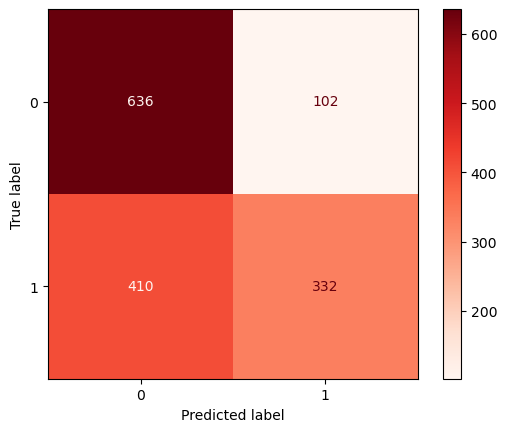

In [51]:
scores.append(evaluate(X_test, y_test, cveclrgs_preds, cveclrgs_model))

In [30]:
tveclrgs.fit(X_train, y_train)

Fitting 5 folds for each of 216 candidates, totalling 1080 fits


GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('tvec', TfidfVectorizer()),
                                       ('lr',
                                        LogisticRegression(max_iter=1000))]),
             param_grid={'lr__C': [0.01, 0.1, 1], 'lr__penalty': ['l2'],
                         'tvec__max_df': [0.85, 0.9, 0.95],
                         'tvec__max_features': [500, 1000, 2000],
                         'tvec__min_df': [0.02, 0.05],
                         'tvec__ngram_range': [(1, 1), (1, 2)],
                         'tvec__stop_words': [None, 'english']},
             verbose=1)

In [31]:
tveclrgs.best_score_

0.6635135135135135

In [32]:
tveclrgs.best_params_

{'lr__C': 1,
 'lr__penalty': 'l2',
 'tvec__max_df': 0.85,
 'tvec__max_features': 500,
 'tvec__min_df': 0.02,
 'tvec__ngram_range': (1, 1),
 'tvec__stop_words': 'english'}

In [33]:
tveclrgs_model = tveclrgs.best_estimator_

In [34]:
tveclrgs_model.score(X_train, y_train)

0.6925675675675675

In [35]:
tveclrgs_model.score(X_test, y_test)

0.6560810810810811

In [36]:
tveclrgs_preds = tveclrgs_model.predict(X_test)

Train: 0.6925675675675675
Test: 0.6560810810810811
Recall: 0.4474393530997305
Precision: 0.7703016241299304


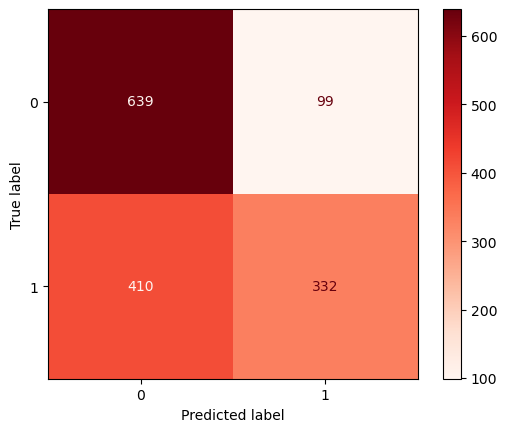

In [37]:
scores.append(evaluate(X_test, y_test, tveclrgs_preds, tveclrgs_model))
plt.savefig("../Images/lrtfidfconfusionmatrix.png")

In [60]:
cvecmnbgs.fit(X_train, y_train)

Fitting 5 folds for each of 144 candidates, totalling 720 fits


GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('cvec', CountVectorizer()),
                                       ('mnb', MultinomialNB())]),
             param_grid={'cvec__max_df': [0.85, 0.9, 0.95],
                         'cvec__max_features': [500, 1000, 2000, 3000],
                         'cvec__min_df': [0.02, 0.03, 0.05],
                         'cvec__ngram_range': [(1, 1), (1, 2)],
                         'cvec__stop_words': [None, 'english']},
             verbose=1)

In [61]:
cvecmnbgs.best_score_

0.6623873873873874

In [62]:
cvecmnbgs.best_params_

{'cvec__max_df': 0.85,
 'cvec__max_features': 500,
 'cvec__min_df': 0.02,
 'cvec__ngram_range': (1, 1),
 'cvec__stop_words': None}

In [63]:
cvecmnbgs_model = cvecmnbgs.best_estimator_

In [64]:
cvecmnbgs_model.score(X_train, y_train)

0.6731981981981981

In [65]:
cvecmnbgs_model.score(X_test, y_test)

0.6452702702702703

In [66]:
cvecmnbgs_preds = cvecmnbgs_model.predict(X_test)

Train: 0.6731981981981981
Test: 0.6452702702702703
Recall: 0.39622641509433965
Precision: 0.7924528301886793


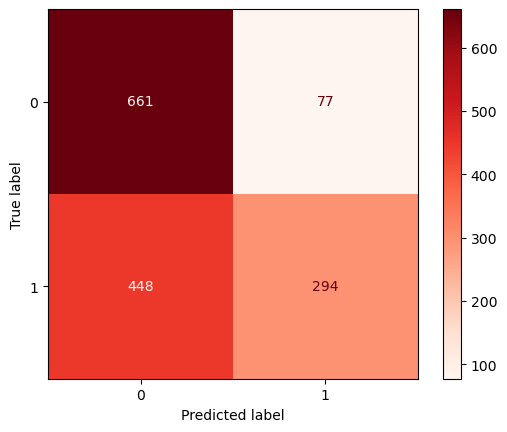

In [67]:
scores.append(evaluate(X_test, y_test, cvecmnbgs_preds, cvecmnbgs_model))

In [68]:
tvecmnbgs.fit(X_train, y_train)

Fitting 5 folds for each of 96 candidates, totalling 480 fits


GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('tvec', TfidfVectorizer()),
                                       ('mnb', MultinomialNB())]),
             param_grid={'tvec__max_df': [0.85, 0.9, 0.95],
                         'tvec__max_features': [500, 1000, 2000, 3000],
                         'tvec__min_df': [0.02, 0.05],
                         'tvec__ngram_range': [(1, 1), (1, 2)],
                         'tvec__stop_words': [None, 'english']},
             verbose=1)

In [69]:
tvecmnbgs.best_score_

0.6495495495495496

In [70]:
tvecmnbgs.best_params_

{'tvec__max_df': 0.85,
 'tvec__max_features': 500,
 'tvec__min_df': 0.02,
 'tvec__ngram_range': (1, 1),
 'tvec__stop_words': 'english'}

In [71]:
tvecmnbgs_model = tvecmnbgs.best_estimator_

In [72]:
tvecmnbgs_model.score(X_train, y_train)

0.6623873873873873

In [73]:
tvecmnbgs_model.score(X_test, y_test)

0.6385135135135135

In [74]:
tvecmnbgs_preds = tvecmnbgs_model.predict(X_test)

Train: 0.6623873873873873
Test: 0.6385135135135135
Recall: 0.5094339622641509
Precision: 0.6885245901639344


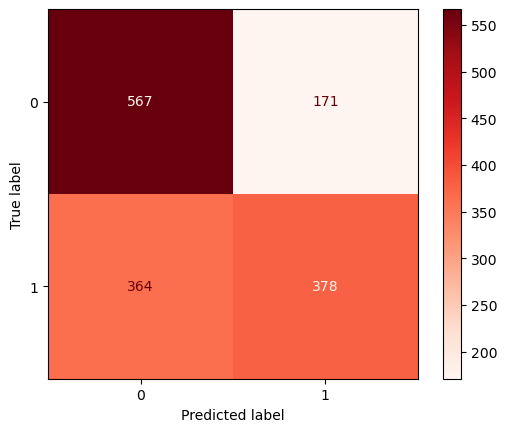

In [75]:
scores.append(evaluate(X_test, y_test, tvecmnbgs_preds, tvecmnbgs_model))

In [76]:
pd.DataFrame(scores, index = ['CVec LogReg', 'TVec LogReg', 
                             'CVec MultiNB', 'TVec MultiNB'])

,Training Accuracy,Test Accuracy,Recall,Precision
CVec LogReg,0.690090,0.654054,0.447439,0.764977
TVec LogReg,0.692568,0.656081,0.447439,0.770302
CVec MultiNB,0.673198,0.645270,0.396226,0.792453
TVec MultiNB,0.662387,0.638514,0.509434,0.688525


Based on the scores on the train and test data of all of the models, the Multinomial Naive Bayes using Count Vectorizer seems to be the most accurate while having the lowest rate of overfitting. This is the model that will be used for classifying posts.